# Segmenting and Clustering Neighbourhoods Toronto
This notebook will be used for the IBM Data Science Professional Certificate week 3 assignment

#### Setting up BeautifulSoup 

In [1]:
import pandas as pd
import numpy as np
import urllib.request
from bs4 import BeautifulSoup

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page = urllib.request.urlopen(url)

In [3]:
soup = BeautifulSoup(page, 'lxml')

#### Scraping data from Wikipedia into a DataFrame

In [4]:
all_tables = soup.find_all('table')

In [5]:
right_table = soup.find('table', class_ = 'wikitable sortable')

In [6]:
# Initialises column lists
Postal_Code = []
Borough = []
Neighbourhood = []

# Scrapes table and inputs data into the column lists
for row in right_table.findAll('tr'):
    cells = row.findAll('td')
    
    if len(cells) == 3:
        Postal_Code.append (cells[0].find(text = True))
        Borough.append (cells[1].find(text = True))
        Neighbourhood.append (cells[2].find(text = True))

In [7]:
# Convert column lists to a pandas dataframe
df = pd.DataFrame(Postal_Code, columns = ['Postal Code'])
df['Borough'] = Borough
df['Neighbourhood'] = Neighbourhood
df[0:5]

,Postal Code,Borough,Neighbourhood
0,M1A\n,Not assigned\n,Not assigned\n
1,M2A\n,Not assigned\n,Not assigned\n
2,M3A\n,North York\n,Parkwoods\n
3,M4A\n,North York\n,Victoria Village\n
4,M5A\n,Downtown Toronto\n,"Regent Park, Harbourfront\n"


#### Cleaning the data

In [8]:
df = df.replace('\n','', regex=True) # Removes the newline characters from the end of the line
df[0:5]

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [9]:
df['Borough'].replace('Not assigned', np.nan, inplace = True) # Converts to NaN values
df.dropna(subset = ['Borough'], axis = 0, inplace = True) # Drops rows in the 'Borough' column with NaN values
df.reset_index(inplace = True) # Resets the index
df.drop('index', axis = 1, inplace = True) # Resets the columns
df.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [10]:
df.shape

(103, 3)

#### Using pgeocode to merge location data

In [11]:
import pgeocode
geolocator = pgeocode.Nominatim('ca') # Creates the geolocator object

In [12]:
# Iterates through the rows and add the latitude and longitude coordinates
i = 0 # Initialises the index number
for row in df.iterrows():
    location = geolocator.query_postal_code(row[1][0]) # Inputs the postal code into the geolocator
    df.loc[i, 'Latitude'] = location.latitude # Inputs the latitude
    df.loc[i, 'Longitude'] = location.longitude # Inputs the longitude
    i += 1 # Increases index by 1

In [13]:
df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.7545,-79.3300
1,M4A,North York,Victoria Village,43.7276,-79.3148
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.6555,-79.3626
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.7223,-79.4504
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6641,-79.3889


In [14]:
df.shape

(103, 5)

#### Analysing Data

In [15]:
df['Borough'].unique()

array(['North York', 'Downtown Toronto', 'Etobicoke', 'Scarborough',
       'East York', 'York', 'East Toronto', 'West Toronto',
       'Central Toronto', 'Mississauga'], dtype=object)

In [16]:
# Find row wih NaN Latitude and Longitude
is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]
rows_with_NaN

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
76,M7R,Mississauga,Canada Post Gateway Processing Centre,NaN,NaN


In [17]:
df.dropna(subset = ['Latitude', 'Longitude'], axis = 0, inplace = True) # Drop row with NaN Latitude and Longitude

In [18]:
from geopy.geocoders import Nominatim
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [19]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

In [20]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)
folium.TileLayer('CartoDB dark_matter').add_to(map_toronto) # Sets Tile Theme to (Dark Theme)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [21]:
tor_df = df[df['Borough'].str.contains('Toronto',na=False)].copy()
tor_df.reset_index(inplace = True)
tor_df.drop('index', axis = 1, inplace = True) # Resets the columns
tor_df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.6555,-79.3626
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6641,-79.3889
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.6572,-79.3783
3,M5C,Downtown Toronto,St. James Town,43.6513,-79.3756
4,M4E,East Toronto,The Beaches,43.6784,-79.2941


In [22]:
map_downtown = folium.Map(location=[latitude, longitude], zoom_start=11)
folium.TileLayer('CartoDB dark_matter').add_to(map_downtown) # Sets Tile Theme to (Dark Theme)

for lat, lng, borough, neighborhood in zip(tor_df['Latitude'], tor_df['Longitude'], tor_df['Borough'], tor_df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_downtown)  
    
map_downtown

#### Using Foursquare to explore Neighbourhoods

In [23]:
CLIENT_ID = 'ZYKPP1HTOC12NWVDPQBSUL5K3Q1U3DM0IIZM3GCYNW2WFAD2' # your Foursquare ID
CLIENT_SECRET = 'OEBRVH4VD0LVPYXPD2RGW3OGF2BTEFOFQYKDXDIKHHOYREQH' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ZYKPP1HTOC12NWVDPQBSUL5K3Q1U3DM0IIZM3GCYNW2WFAD2
CLIENT_SECRET:OEBRVH4VD0LVPYXPD2RGW3OGF2BTEFOFQYKDXDIKHHOYREQH


##### Explore the area around the CN Tower

In [24]:
tor_df[tor_df['Neighbourhood'].str.contains('CN Tower')]

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
32,M5V,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har...",43.6404,-79.3995


In [25]:
CN_name = tor_df.loc[32, 'Neighbourhood'] # neighborhood name
CN_latitude = tor_df.loc[32, 'Latitude'] # neighborhood latitude value
CN_longitude = tor_df.loc[32, 'Longitude'] # neighborhood longitude value

print('Latitude and longitude values of {} are {}, {}.'.format(CN_name, 
                                                               CN_latitude, 
                                                               CN_longitude))

Latitude and longitude values of CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport are 43.6404, -79.3995.


Importing modules to work with JSON files and url requests

In [26]:
import json
from pandas import json_normalize
import requests

In [27]:
radius = 500
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    CN_latitude, 
    CN_longitude, 
    radius, 
    LIMIT)
url # display URL


'https://api.foursquare.com/v2/venues/explore?&client_id=ZYKPP1HTOC12NWVDPQBSUL5K3Q1U3DM0IIZM3GCYNW2WFAD2&client_secret=OEBRVH4VD0LVPYXPD2RGW3OGF2BTEFOFQYKDXDIKHHOYREQH&v=20180605&ll=43.6404,-79.3995&radius=500&limit=100'

In [28]:
results = requests.get(url).json()

In [29]:
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)

In [30]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

In [31]:
i = 0 # Initialises the index number
for row in nearby_venues.iterrows():
    nearby_venues.loc[i, 'venue.categories'] = nearby_venues.loc[i,'venue.categories'][0]['name']
    i += 1 # Increases index by 1

In [32]:
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues.head()

,name,categories,lat,lng
0,Stackt,Market,43.640815,-79.401547
1,Sansotei Ramen,Ramen Restaurant,43.639176,-79.398184
2,Victoria Memorial Park,Park,43.642785,-79.399590
3,Roywoods,Caribbean Restaurant,43.639099,-79.398449
4,Thor Espresso Bar,Café,43.641998,-79.401759


##### Explore neighbourhood in Toronto

In [33]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [34]:
downtown_venues = getNearbyVenues(tor_df['Neighbourhood'],
                                   latitudes=tor_df['Latitude'],
                                   longitudes=tor_df['Longitude']
                                  )


Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West,  Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport


In [35]:
downtown_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.6555,-79.3626,Tandem Coffee,43.653559,-79.361809,Coffee Shop
1,"Regent Park, Harbourfront",43.6555,-79.3626,Roselle Desserts,43.653447,-79.362017,Bakery
2,"Regent Park, Harbourfront",43.6555,-79.3626,Figs Breakfast & Lunch,43.655675,-79.364503,Breakfast Spot
3,"Regent Park, Harbourfront",43.6555,-79.3626,The Yoga Lounge,43.655515,-79.364955,Yoga Studio
4,"Regent Park, Harbourfront",43.6555,-79.3626,Body Blitz Spa East,43.654735,-79.359874,Spa


In [36]:
downtown_venues.shape

(1541, 7)

In [37]:
count_df = downtown_venues.groupby("Neighbourhood").count().sort_values(by = "Venue", ascending = False)

In [38]:
count_df.reset_index(inplace = True)

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Number of Venues per Neighbourhood')

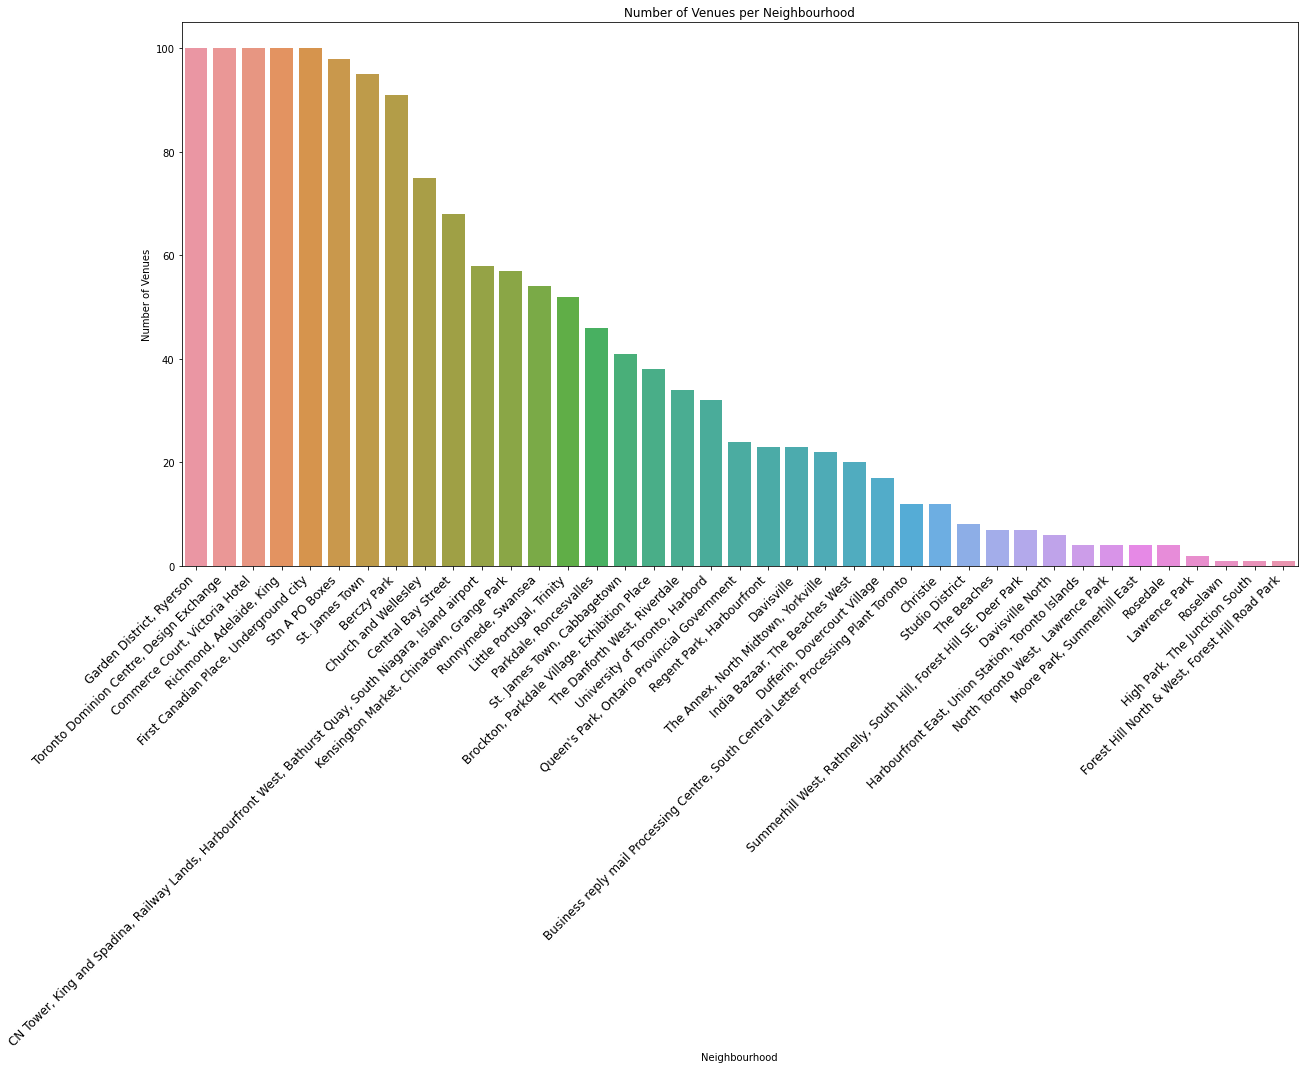

In [40]:
fig = plt.figure(figsize = (20,10))

ax = sns.barplot(x = count_df['Neighbourhood'], y = count_df['Venue'])

plt.xticks(rotation = 45, horizontalalignment='right', fontweight='light', fontsize='large')
plt.ylabel("Number of Venues")
plt.title("Number of Venues per Neighbourhood")

#### Cluster each Neighbourhood

In [41]:
toronto_onehot = pd.get_dummies(downtown_venues[['Venue Category']], prefix = "", prefix_sep="")

In [42]:
toronto_onehot['Neighbourhood'] = downtown_venues['Neighbourhood']

In [43]:
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_onehot.head()

,Neighbourhood,Accessories Store,Afghan Restaurant,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
toronto_grouped = toronto_onehot.groupby("Neighbourhood").mean().reset_index()
toronto_grouped.head()

,Neighbourhood,Accessories Store,Afghan Restaurant,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Berczy Park,0.000000,0.0,0.010989,0.021978,0.000000,0.000000,0.000000,0.0,0.010989,...,0.0,0.010989,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.010989
1,"Brockton, Parkdale Village, Exhibition Place",0.026316,0.0,0.000000,0.026316,0.000000,0.026316,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
2,"Business reply mail Processing Centre, South C...",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.083333
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.017241,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.017241,0.0,0.017241
4,Central Bay Street,0.000000,0.0,0.000000,0.000000,0.014706,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.014706,0.014706,0.0,0.014706,0.0,0.000000,0.0,0.000000


In [45]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

In [46]:
toronto_grouped_clusetering = toronto_grouped.drop("Neighbourhood", axis = 1)

In [47]:
k = 5
k_means = KMeans(n_clusters = k, init = 'k-means++', n_init = 12).fit(toronto_grouped_clusetering)

In [48]:
k_means.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 2, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [49]:
k_means.cluster_centers_

array([[7.97448166e-04, 4.04040404e-04, 9.80850647e-03, ...,
        5.22466040e-04, 9.09090909e-04, 8.48847587e-03],
       [0.00000000e+00, 0.00000000e+00, 1.73472348e-18, ...,
        0.00000000e+00, 1.08420217e-19, 8.67361738e-19],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [50]:
toronto_grouped.insert(1,'Cluster Labels', k_means.labels_)
toronto_grouped.head()

,Neighbourhood,Cluster Labels,Accessories Store,Afghan Restaurant,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Berczy Park,0,0.000000,0.0,0.010989,0.021978,0.000000,0.000000,0.000000,0.0,...,0.0,0.010989,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.010989
1,"Brockton, Parkdale Village, Exhibition Place",0,0.026316,0.0,0.000000,0.026316,0.000000,0.026316,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
2,"Business reply mail Processing Centre, South C...",0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.083333
3,"CN Tower, King and Spadina, Railway Lands, Har...",0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.017241,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.017241,0.0,0.017241
4,Central Bay Street,0,0.000000,0.0,0.000000,0.000000,0.014706,0.000000,0.000000,0.0,...,0.0,0.000000,0.014706,0.014706,0.0,0.014706,0.0,0.000000,0.0,0.000000


In [51]:
tor_df.insert(2,'Cluster Labels', k_means.labels_)
tor_df.head()

,Postal Code,Borough,Cluster Labels,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,0,"Regent Park, Harbourfront",43.6555,-79.3626
1,M7A,Downtown Toronto,0,"Queen's Park, Ontario Provincial Government",43.6641,-79.3889
2,M5B,Downtown Toronto,0,"Garden District, Ryerson",43.6572,-79.3783
3,M5C,Downtown Toronto,0,St. James Town,43.6513,-79.3756
4,M4E,East Toronto,0,The Beaches,43.6784,-79.2941


In [52]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
folium.TileLayer('CartoDB dark_matter').add_to(map_clusters) # Sets Tile Theme to (Dark Theme)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tor_df['Latitude'], tor_df['Longitude'], tor_df['Neighbourhood'], tor_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

##### Finding the optimal k

In [53]:
from sklearn.metrics import silhouette_score

In [54]:
sil = []
kmax = 38

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
    k_means = KMeans(n_clusters = k, init = 'k-means++', n_init = 20).fit(toronto_grouped_clusetering)
    labels = k_means.labels_
    sil.append(silhouette_score(toronto_grouped_clusetering, labels, metric = 'euclidean'))

sil[0:5]

[0.5101003225321622,
 0.5240610845814233,
 0.5383992748337266,
 0.31187495358075434,
 0.35922721279474057]

<function matplotlib.pyplot.show(*args, **kw)>

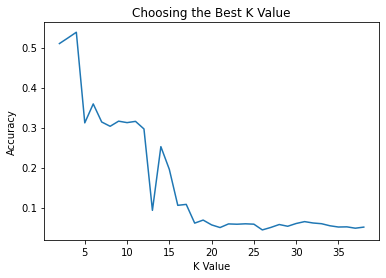

In [55]:
plt.plot(range(2,kmax+1), sil)
plt.title("Choosing the Best K Value")
plt.xlabel("K Value")
plt.ylabel("Accuracy")
plt.show

In [56]:
print( "The best accuracy was with", max(sil), "with k=", np.argmax(sil)+2) 

The best accuracy was with 0.5383992748337266 with k= 4


Since the most accurate model has 3 clusters, we will redo the clustering

In [57]:
k = np.argmax(sil)+2
k_means3 = KMeans(n_clusters = k, init = 'k-means++', n_init = 20).fit(toronto_grouped_clusetering)

In [58]:
k_means3.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3, 0, 0, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [59]:
tor_df.drop('Cluster Labels', axis = 1, inplace = True)
tor_df.insert(2,'Cluster Labels', k_means3.labels_)
tor_df.head()

,Postal Code,Borough,Cluster Labels,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,0,"Regent Park, Harbourfront",43.6555,-79.3626
1,M7A,Downtown Toronto,0,"Queen's Park, Ontario Provincial Government",43.6641,-79.3889
2,M5B,Downtown Toronto,0,"Garden District, Ryerson",43.6572,-79.3783
3,M5C,Downtown Toronto,0,St. James Town,43.6513,-79.3756
4,M4E,East Toronto,0,The Beaches,43.6784,-79.2941


In [60]:
tor_df.groupby("Cluster Labels").count()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
Cluster Labels,,,,,
0,35,35,35,35,35
1,1,1,1,1,1
2,1,1,1,1,1
3,2,2,2,2,2


In [61]:
map_clusters_k_3 = folium.Map(location=[latitude, longitude], zoom_start=11)
folium.TileLayer('CartoDB dark_matter').add_to(map_clusters_k_3) # Sets Tile Theme to (Dark Theme)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tor_df['Latitude'], tor_df['Longitude'], tor_df['Neighbourhood'], tor_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_k_3)
       
map_clusters_k_3